In [30]:
from ipstartup import *
croot = "c:" if os.name=="nt" else "/mnt/c"
droot = "d:" if os.name=="nt" else "/mnt/d"
os.chdir(f"{droot}/data1")
sys.path.append(f"{croot}/Users/simon/OneDrive/Documents/py/live/slab/src")
############################################################################
from transformers import pipeline
import numpy as np
import pandas as pd
from model.utils import *

# feature_extraction => sents,bs=1,tokens,features=768
model = "nbroad/ESG-BERT"
pipe = pipeline('feature-extraction', model=model)

[cellevents:43:INFO]:starting (time=Jul-08 09:45 MainProcess)
Some weights of the model checkpoint at nbroad/ESG-BERT were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


time: 10.9 s


In [31]:
# load data
sents = pd.read_csv("Clean_sentences.csv").Sentences.tolist()
sents = [s.replace("_"," ") for s in sents]
sents = Document(sents, pipe)
kpis = pd.read_excel("SustainLab_Generic_Granular_KPI list.xlsx", sheet_name="Granular KPI list").KPI.tolist()
kpis = Document(kpis, pipe)

[cellevents:43:INFO]:starting (time=Jul-08 09:45 MainProcess)


time: 179 ms


In [32]:
# get features
sents.get_feats()
kpis.get_feats()

[cellevents:43:INFO]:starting (time=Jul-08 09:45 MainProcess)


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

time: 31.2 s


# sentence embedding

In [33]:
# sentence embedding
sentdf = sents.compare_sents(kpis)
sentdf.sample(3)

[cellevents:43:INFO]:starting (time=Jul-08 09:46 MainProcess)


,kpi,score
sent,,
"the timer lowers the indoor temperature when no one is present, eliminating wasteful use by floor, thereby achieving about a 30% reduction in energy consumption as compared to an ordinary central air conditioning system.",total heating energy sold,0.832714
"in addition to these benefits, an lca we conducted determined that hp instant ink on average decreases the carbon footprint of ink purchase and distribution by 73%, while reducing energy use by 69% and lowering water use by 70%, compared with cartridge purchase and recycling through traditional 84 hp 2020 sustainable impact report footprint integrity and human rights retail channels.",total fuel consumption from renewable sources,0.702736
"manufacturing although accounting for a small portion of our total lifecycle emissions, electrolux has reduced the energy use per product by 45% since 2005.",Total weight or volume of non-renewable materi...,0.732722


time: 16.5 ms


# ngram embedding

In [34]:
# inspect ngram embedding dataframe on a sentence
# note ngrams are within the context of the sentence. "energy" has different embeddings in different sentences.
i = np.random.randint(len(sents.sents))
ngram, kpi, score, ngramdf1 = sents.compare_ngrams(i, kpis, 5)
sent = pipe.tokenizer.decode(pipe.tokenizer.encode(sents.sents[i]))
print(i, sent)
ngramdf1[:10]

[cellevents:43:INFO]:starting (time=Jul-08 09:46 MainProcess)


39 [CLS] in 2020, our solar energy consumption increased from 1 % to 3 %, helping us save 7, 408 mwh. [SEP]


,best,score
ngram,,
our solar energy consumption increased,amount of energy consumption reduced,0.921617
mwh. [SEP],amount of energy consumption reduced,0.920483
our solar energy consumption,amount of energy consumption reduced,0.920439
", our solar energy consumption",amount of energy consumption reduced,0.919891
solar energy consumption increased,amount of energy consumption reduced,0.919180
##h. [SEP],amount of energy consumption reduced,0.918977
consumption,amount of energy consumption reduced,0.917295
solar energy consumption,amount of energy consumption reduced,0.917209
"2020, our solar energy",amount of energy consumption reduced,0.916838


time: 78.6 ms


In [35]:
# ngrams for all sentences
res = []
for i, sent in enumerate(tqdm(sents.sents)):
    ngram, kpi, score, _ = sents.compare_ngrams(i, kpis)
    res.append([sent, ngram, kpi, score])
ngramdf = pd.DataFrame(res, columns=["sent", "ngram", "kpi", "score"])
ngramdf = ngramdf.set_index("sent")

[cellevents:43:INFO]:starting (time=Jul-08 09:46 MainProcess)


  0%|          | 0/126 [00:00<?, ?it/s]

time: 52.9 s


[cellevents:43:INFO]:starting (time=Jul-08 09:47 MainProcess)


<AxesSubplot:>

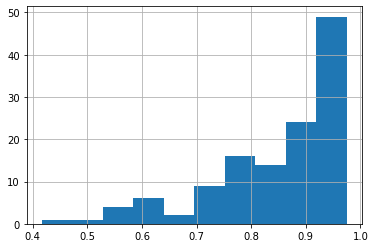

time: 344 ms


In [36]:
ngramdf.score.hist()

In [37]:
out = ngramdf.join(sentdf, rsuffix="_sent")[["ngram", "kpi", "score", "kpi_sent", "score_sent"]]
out.to_excel("sent_ngram.xlsx")

[cellevents:43:INFO]:starting (time=Jul-08 09:47 MainProcess)


time: 67.2 ms


In [38]:
out.sort_values("score", ascending=False)[:10]

[cellevents:43:INFO]:starting (time=Jul-08 09:47 MainProcess)


,ngram,kpi,score,kpi_sent,score_sent
sent,,,,,
products and solutions appendix water water withdrawal associated with our operations makes up 2% of our total water footprint.,[CLS] products and solutions appendix water wa...,total third-party water withdrawal with water ...,0.974464,total third-party water withdrawal with water ...,0.972459
"reduce scope 1 and scope 2 ghg emissions hps global operations produced 171,000 13 from global operations by 60% by 2025, tonnes of scope 1 and scope 2 co.e compared to 2015.""",[CLS] reduce scope 1 and scope 2 ghg emissions,Scope 2 GHG emissions of CO2 equivalent,0.964580,Scope 2 GHG emissions of CO2 equivalent,0.951864
"while ghg emissions from our operations only represent 1% of our footprint, we work to demonstrate leadership in emissions management, reduction, and disclosure.",[CLS] while ghg emissions,co2 equivalent of GHG emissions reduced,0.958361,co2 equivalent of GHG emissions reduced,0.939852
"water scarcity levels are rising-14 out of 20 of the worlds largest cities are already experiencing inadequate supplies and two-thirds of the worlds population are expected to live in water-stressed areas by 2025. still, the average daily water consumption per person is up to 500 liters in some developed countries and approximately 16% of energy consumption in the home is related to water usage.",water usage.,total water consumption with water stress,0.956143,total water withdrawal in megaliters,0.944818
"after reducing ghg emissions by 77% through energy efficiency, the site offset the remaining 23% of ghg emissions plus an additional 20% of the original amount.",ghg emissions,co2 equivalent of GHG emissions reduced,0.955491,co2 equivalent of GHG emissions reduced,0.939440
greenhouse gas emissions were reduced by 242 tons of carbon dioxide equivalent per year.,[CLS] greenhouse,co2 equivalent of GHG emissions reduced,0.954785,co2 equivalent of GHG emissions reduced,0.941641
this action is estimated to bring a 30% (2.6 mwh/year) reduction in energy consumption.,in energy consumption. [SEP],amount of energy consumption reduced,0.954194,amount of energy consumption reduced,0.936609
"reduce first-tier production supplier through december 2019 (the most recent 13 and product transportation-related ghg year data is available), ghg emissions emissions intensity by 10% by 2025, intensity decreased 3%, compared to 2015.",", ghg emissions",co2 equivalent of GHG emissions reduced,0.954100,co2 equivalent of GHG emissions reduced,0.930434
170 business leaders call on eu decision-makers to support a greenhouse gas (ghg) emissions reduction target of at least 55% by 2030.,ghg ) emissions,co2 equivalent of GHG emissions reduced,0.952568,Scope 2 GHG emissions of CO2 equivalent,0.932535


time: 16.2 ms


In [39]:
out.sort_values("score", ascending=False)[-10:]

[cellevents:43:INFO]:starting (time=Jul-08 09:47 MainProcess)


,ngram,kpi,score,kpi_sent,score_sent
sent,,,,,
"this includes materials such as autoclaved aerated concrete, which is a lightweight, precast, foam concrete building material that helps reduce at least 30% in industrial waste, 50% in greenhouse radiation and over 60% of integrated energy on the surface of bricks.","waste,",particulate matter,0.607838,particulate matter,0.598814
"the system also helps cut co, emissions by 61% compared to bottled water and reduce plastic waste.",emissions,persistent organic pollutants,0.597340,persistent organic pollutants,0.579199
"research shows that extending the lifespan of clothing by an extra nine months by taking better care of clothes can reduce carbon, waste and water footprints by between 20% and 30%.",%. [SEP],percentage of recycled materials used in manuf...,0.596580,percentage of recycled materials used in manuf...,0.584994
"key priorities and progress 2020 in 2020, electrolux launched the 'for the better 2030' sustainability framework, including the objective to make our business circular and climate neutral by 2030. this new target complements our science-based target to reduce our scope land 2 emissions by 80% between 2015 and 2025. read more about our climate targets.",emissions,emissions in base year,0.595067,emissions in base year,0.518653
"instead of disposing of the oil after first use, we filter the used oil and use it for topping up, a:: transforming our portfolios to low-carbon sustainable cities which reduces the amount of new oil required.",- carbon sustainable cities which reduces the ...,Total weight or volume of non-renewable materi...,0.568819,percentage of recycled materials used in manuf...,0.554812
our zero landfill program has the objective to reduce the amount of waste sent to landfll or incinerated without energy recovery.,recovery. [SEP],persistent organic pollutants,0.545644,persistent organic pollutants,0.529074
"se 00 ee 07 es 003 @ electricity consumption per kg of waste treated (kwh/kg) the increase observed in the average consumption per 100 km is due to the fact that in 2020, new and more de- manding routes were added for sterilisation s.a.",of waste treated (,particulate matter,0.543269,persistent organic pollutants,0.527370
the steamcare program for example uses steam-and up to 96% less water-to freshen clothes and remove wrinkles.,##inkles.,rate of fatalities due to work-related injury,0.530545,rate of fatalities due to work-related injury,0.474987
"taken together, these measures help us reduce the carbon footprint of our glazed balconies by 30 percent -from 5,000 kg co, to 3,500 kg co,e-while also reducing the repayment period on the climate debt.",##ment,community investments,0.476228,community investments,0.432080


time: 22 ms


In [40]:
out[out.kpi!=out.kpi_sent].sort_values("score", ascending=False).sample(10)

[cellevents:43:INFO]:starting (time=Jul-08 09:47 MainProcess)


,ngram,kpi,score,kpi_sent,score_sent
sent,,,,,
"instead of disposing of the oil after first use, we filter the used oil and use it for topping up, a:: transforming our portfolios to low-carbon sustainable cities which reduces the amount of new oil required.",- carbon sustainable cities which reduces the ...,Total weight or volume of non-renewable materi...,0.568819,percentage of recycled materials used in manuf...,0.554812
"[sbt] e by further promoting energy saving for existing facilities and achieving zeb for facilities to be newly constructed, we aim to increase the groupwide energy efficiency (sales unit per consumed energy) by half by 2030 and double it by 2040 trom the fiscal 2015 levels.",##wide energy efficiency,total heating energy consumption,0.938987,energy consumption outside of the organization,0.934252
"since 2015, use has been reduced by 26 percent, due largely to the continued conversion to biofuels in th ghg emissions from nccs operations e swedish asphalt plants.",ghg emissions from,co2 equivalent of GHG emissions reduced,0.947065,Scope 2 GHG emissions of CO2 equivalent,0.930576
the ultrawash cycle is the ideal balance of care and energy-efficiency for mixed loads-a 59-minute cycle at 350c saves up to 30% energy compared to a 40c cotton program.,[CLS] the ultrawash cycle,energy consumption outside of the organization,0.917525,amount of energy consumption reduced,0.897090
"energy efficiency and greenhouse gas reduction approximately 85% of the energy consumed during the multi-decade lifecycle of a homeincluding the initial raw material extraction, manufacturing, and constructioncomes from the day-to-day living in it.",.,gross market GHG emissions of CO2 equivalent,0.750007,ratio of energy intensity of the organization,0.683441
"we also converted to 100% renewable energy at the lixil headquarters, kyoto showroom, and inax museums, achieving an annual carbon reduction of 2,000 metric tons.",metric tons. [SEP],energy consumption outside of the organization,0.862242,ratio of energy intensity of the organization,0.848135
"in our group, ghg emissions derived from our business activities are as low as 1.3% for scopes 1 and 2 and our scope 3 emissions (indirect emissions from sources other than our company) account for the majority of 98.7%.",", ghg",Scope 1 GHG emissions of CO2 equivalent,0.951311,co2 equivalent of GHG emissions reduced,0.930687
"in fye 2020, all grohe production sites achieved a shift to renewable energy, reducing co, emissions by 48,000 metric tons annually.",renewable energy,total fuel consumption from renewable sources,0.762515,ratio of energy intensity of the organization,0.721169
"se 00 ee 07 es 003 @ electricity consumption per kg of waste treated (kwh/kg) the increase observed in the average consumption per 100 km is due to the fact that in 2020, new and more de- manding routes were added for sterilisation s.a.",of waste treated (,particulate matter,0.543269,persistent organic pollutants,0.527370


time: 18.5 ms
